# Frequentist Linear Model

## Librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from src.preprocessing import PreprocessDataTrainTestSplit
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import  StandardScaler

In [2]:
root_path = Path(os.getcwd())
data_path = root_path.joinpath("Macro1.csv")

In [3]:
preprocess_train_test = PreprocessDataTrainTestSplit(data_path=data_path, split_date='1999-12-01', columns_to_del=['IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS'], normalize=False, max_date='2006-12-31')
train_df, test_df = preprocess_train_test.process()

X = train_df.drop('INDPRO', axis=1).values
y = train_df['INDPRO'].values

X_test = test_df.drop('INDPRO', axis=1).values
y_test = test_df['INDPRO'].values

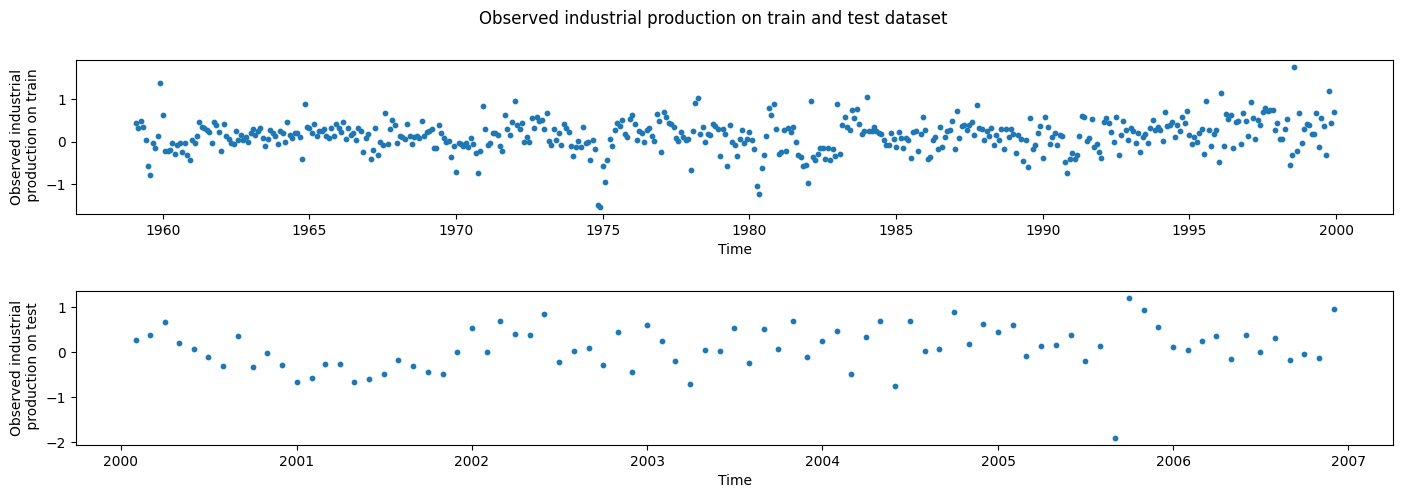

In [4]:
plt.figure(figsize=(17,5))
plt.subplot(2, 1, 1)
plt.scatter(train_df.index, y, marker='o', s=10, label="True label")
plt.xlabel('Time')
plt.ylabel("Observed industrial\n production on train")

plt.subplot(2, 1, 2)
plt.scatter(test_df.index, y_test, marker='o', s=10, label="True label")
plt.xlabel('Time')
plt.ylabel("Observed industrial\n production on test")

plt.subplots_adjust(hspace=0.5)
plt.suptitle("Observed industrial production on train and test dataset")
plt.show()

## Lasso Regression: choice of penalization hyperparameter

In [5]:
scaler = StandardScaler()
X_transform = scaler.fit_transform(X)
X_test_transform = scaler.transform(X_test)

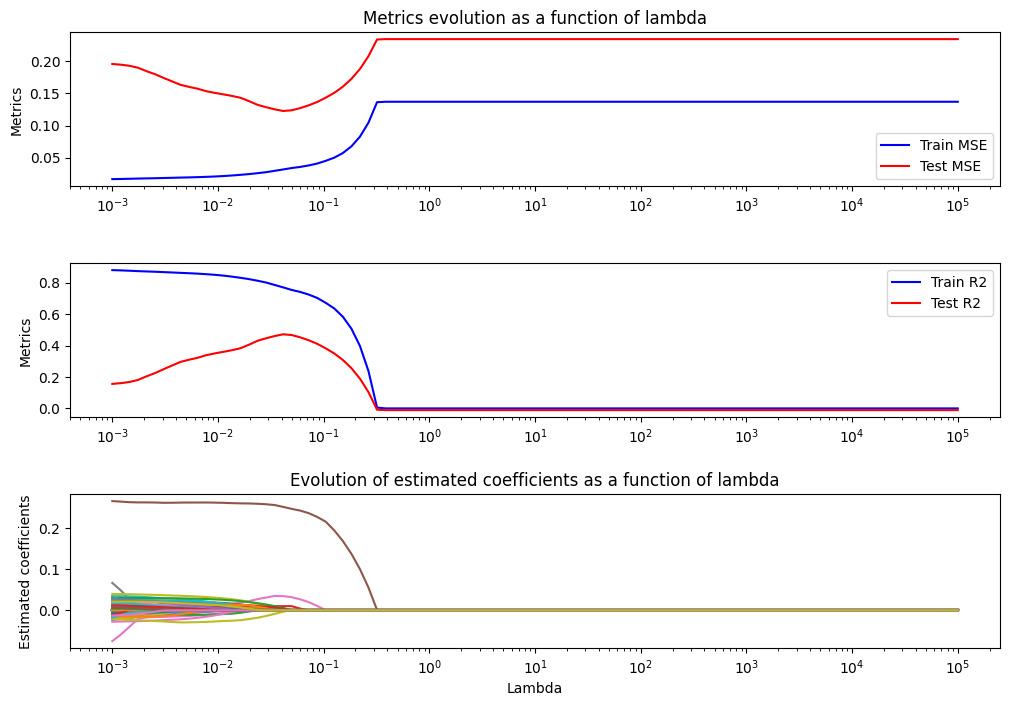

In [6]:
## Loop over lambda
range_alpha=np.logspace(-3, 5, 100)
list_mse_train=[]
list_mse_test=[]
list_r2_train=[]
list_r2_test=[]
list_parameters=[]

for alpha in range_alpha:
    lasso=Lasso(alpha=alpha)
    lasso.fit(X_transform, y)
    y_pred_train=lasso.predict(X_transform)
    y_pred_test=lasso.predict(X_test_transform)

    mse_train=mean_squared_error(y, y_pred_train)
    mse_test=mean_squared_error(y_test, y_pred_test)
    r2_train=r2_score(y, y_pred_train)
    r2_test=r2_score(y_test, y_pred_test)
    list_parameters_lasso=list(lasso.coef_)

    list_mse_train.append(mse_train)
    list_mse_test.append(mse_test)
    list_r2_train.append(r2_train)
    list_r2_test.append(r2_test)
    list_parameters.append(list_parameters_lasso)

array_parameters=np.array(list_parameters)

## Plots
plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=0.5)

plt.subplot(3, 1, 1)

plt.semilogx(range_alpha, list_mse_train, color='blue', label="Train MSE")
plt.plot(range_alpha, list_mse_test, color='red', label="Test MSE")
plt.ylabel("Metrics")
plt.legend()
plt.title("Metrics evolution as a function of lambda")

plt.subplot(3,1,2)
plt.semilogx(range_alpha, list_r2_train, color='blue', label="Train R2")
plt.plot(range_alpha, list_r2_test, color='red', label="Test R2")
plt.ylabel("Metrics")
plt.legend()

plt.subplot(3,1,3)
for j in range(array_parameters.shape[1]):
    plt.semilogx(range_alpha, array_parameters[:,j])
plt.xlabel("Lambda")
plt.ylabel("Estimated coefficients")
plt.title("Evolution of estimated coefficients as a function of lambda")
plt.show()

In [7]:
index_min_mse=np.argmin(list_mse_test)
optimal_lambda=range_alpha[index_min_mse]
print("Lambda minimizing test MSE: {}".format(round(optimal_lambda, 2)))

Lambda minimizing test MSE: 0.04


In [8]:
alpha = 0.04

# Cross validation

Train R2: 0.9173273680964893
Train MSE: 0.006952392562215638
Val R2: 0.7646675494055948
Val MSE: 0.020405999813075705


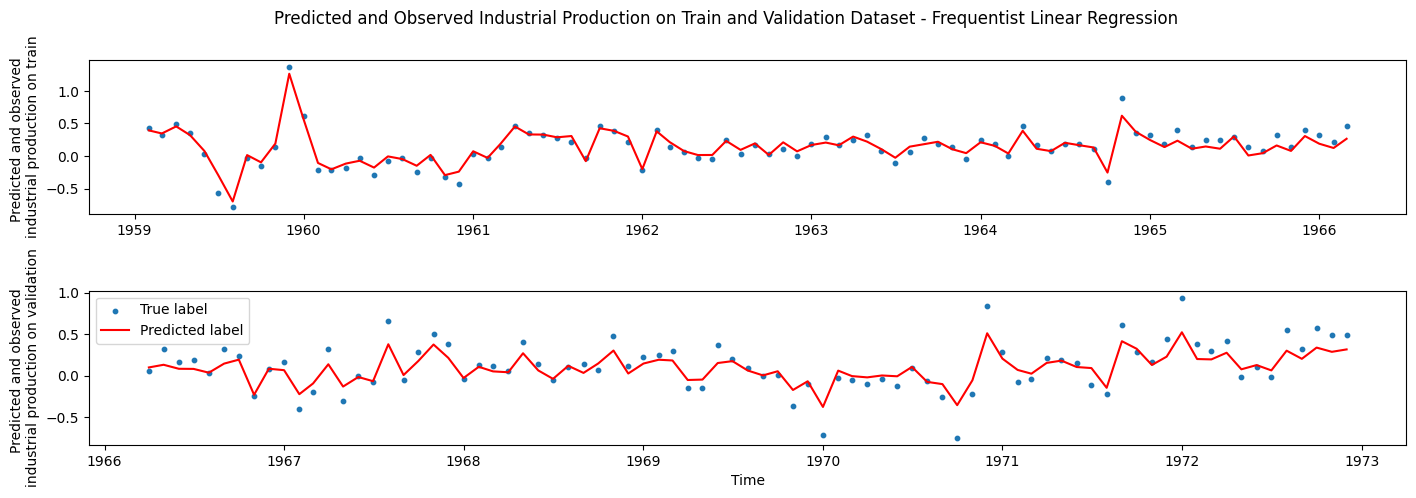

Train R2: 0.8838820913836124
Train MSE: 0.009920404400559267
Val R2: 0.7421750668405815
Val MSE: 0.04553447933466495


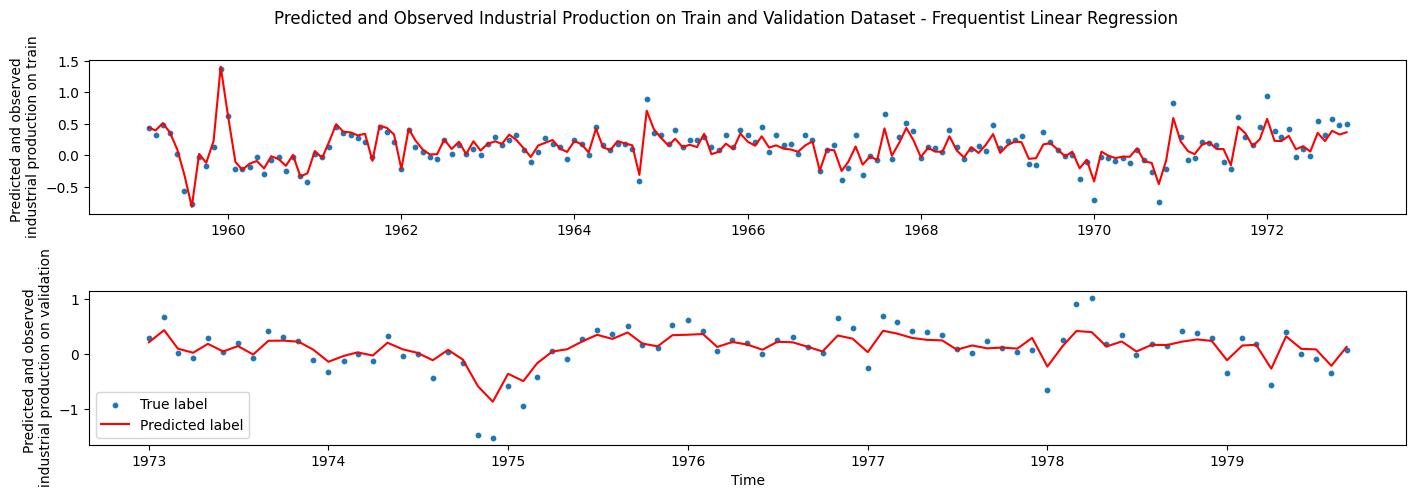

Train R2: 0.8808370712424435
Train MSE: 0.013760659177092328
Val R2: 0.7345793311582476
Val MSE: 0.04955861751966914


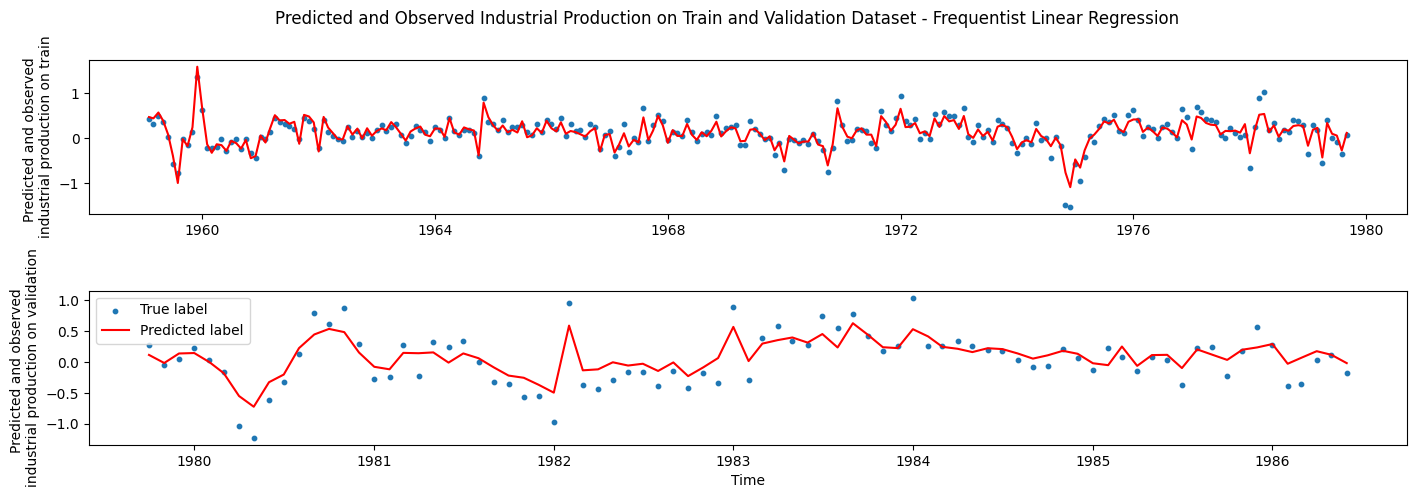

Train R2: 0.853225326387181
Train MSE: 0.01967834588693545
Val R2: 0.6531869668151831
Val MSE: 0.034438183742294515


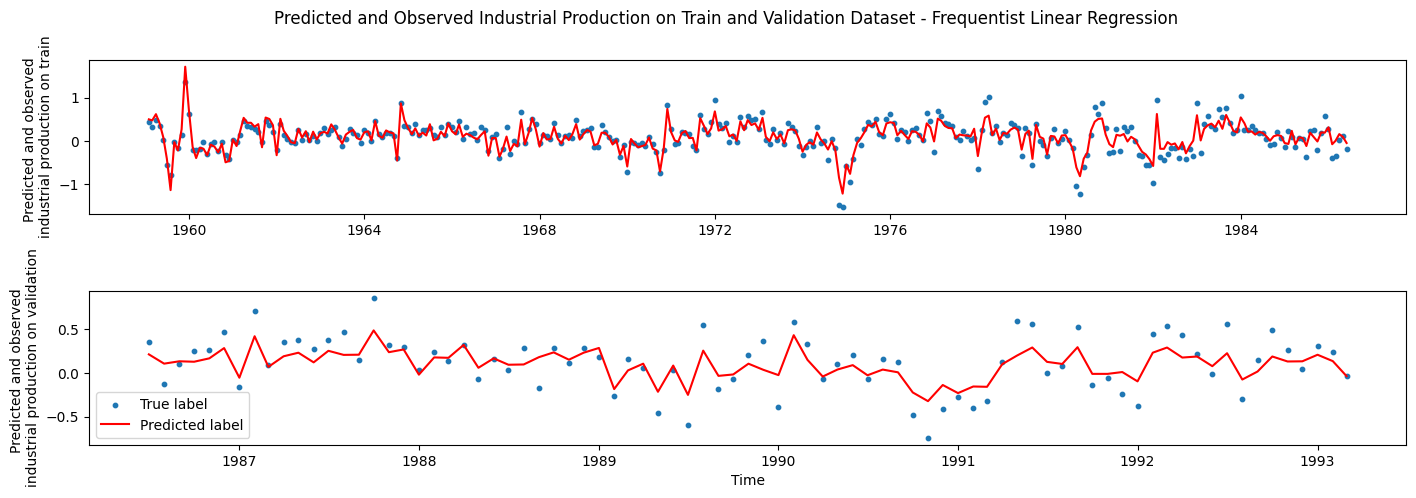

Train R2: 0.8247591854793592
Train MSE: 0.02230376086598747
Val R2: 0.2720752665068804
Val MSE: 0.10600680220923502


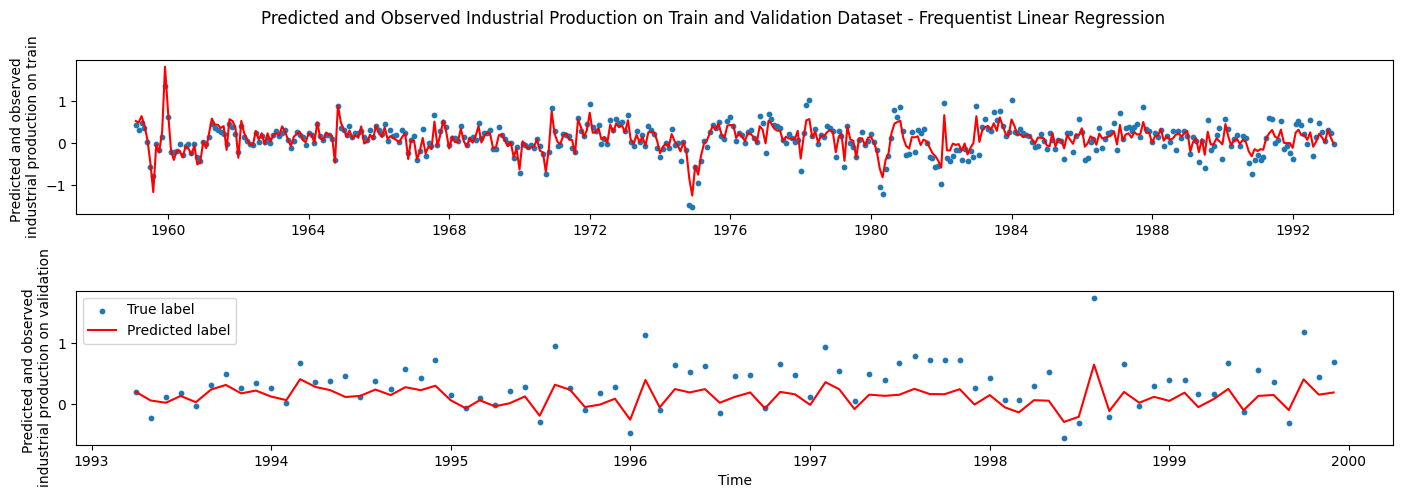

Average MSE - train: 0.01452311257855803
Average R2 - train: 0.8720062085178171
Average MSE - validation: 0.05118881652378786
Average R2 - validation: 0.6333368361452976


In [13]:
lasso = Lasso(alpha=alpha)
tscv = TimeSeriesSplit(n_splits=5)
list_mse_train = []
list_r2_train = []
list_mse_val = []
list_r2_val = []
list_beta_pred = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index, :], X[val_index, :]
    y_train, y_val = y[train_index], y[val_index]

    scaler = StandardScaler()
    X_train_transform = scaler.fit_transform(X_train)
    X_val_transform = scaler.transform(X_val)
    
    lasso.fit(X_train_transform, y_train)
    list_beta_pred.append(lasso.coef_)
    y_pred_train = lasso.predict(X_train_transform)
    y_pred_val = lasso.predict(X_val_transform)

    r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)

    list_mse_train.append(mse_train)
    list_r2_train.append(r2_train)
    list_mse_val.append(mse_val)
    list_r2_val.append(r2_val)

    print("Train R2: {}".format(r2_train))
    print("Train MSE: {}".format(mse_train))
    print("Val R2: {}".format(r2_val))
    print("Val MSE: {}".format(mse_val))

    plt.figure(figsize=(17,5))
    plt.subplot(2, 1, 1)
    plt.scatter(train_df.index[train_index], y_train, marker='o', s=10, label="True label")
    plt.plot(train_df.index[train_index], y_pred_train, color='red', label="Predicted label")
    plt.ylabel("Predicted and observed \nindustrial production on train")

    plt.subplot(2, 1, 2)
    plt.scatter(train_df.index[val_index], y_val, marker='o', s=10, label="True label")
    plt.plot(train_df.index[val_index], y_pred_val, color='red', label="Predicted label")
    plt.xlabel('Time')
    plt.ylabel("Predicted and observed \nindustrial production on validation")
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Predicted and Observed Industrial Production on Train and Validation Dataset - Frequentist Linear Regression")
    plt.legend()
    plt.show()

print("Average MSE - train: {}".format(sum(list_mse_train)/len(list_mse_train)))
print("Average R2 - train: {}".format(sum(list_r2_train)/len(list_r2_train)))
print("Average MSE - validation: {}".format(sum(list_mse_val)/len(list_mse_val)))
print("Average R2 - validation: {}".format(sum(list_r2_val)/len(list_r2_val)))

In [14]:
for i in range(len(list_beta_pred)):
    print("Number of zero components: {}".format(len(list_beta_pred[i])-np.count_nonzero(list_beta_pred[i])))

Number of zero components: 106
Number of zero components: 106
Number of zero components: 104
Number of zero components: 99
Number of zero components: 103


# Simple Validation

In [10]:
lasso = Lasso(alpha=alpha)
lasso.fit(X_transform, y)
y_pred_train = lasso.predict(X_transform)
y_pred_test = lasso.predict(X_test_transform)

r2_train = r2_score(y, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Train R2: {}".format(r2_train))
print("Test R2: {}".format(r2_test))
print("Train MSE: {}".format(mse_train))
print("Test MSE: {}".format(mse_test))

Train R2: 0.7728874145522958
Test R2: 0.4701885662223987
Train MSE: 0.031140222279385153
Test MSE: 0.12303899376748006


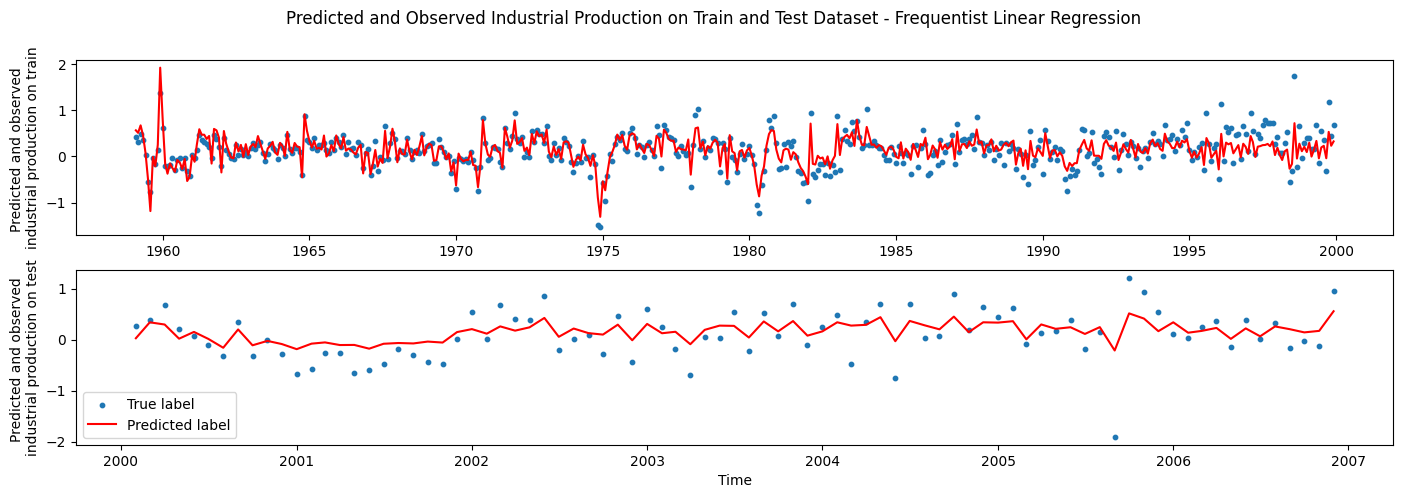

In [11]:
plt.figure(figsize=(17,5))
plt.subplot(2, 1, 1)
plt.scatter(train_df.index, y, marker='o', s=10, label="True label")
plt.plot(train_df.index, y_pred_train, color='red', label="Predicted label")
plt.ylabel("Predicted and observed \nindustrial production on train")

plt.subplot(2, 1, 2)
plt.scatter(test_df.index, y_test, marker='o', s=10, label="True label")
plt.plot(test_df.index, y_pred_test, color='red', label="Predicted label")
plt.xlabel('Time')
plt.ylabel("Predicted and observed \nindustrial production on test")

plt.suptitle("Predicted and Observed Industrial Production on Train and Test Dataset - Frequentist Linear Regression")
plt.legend()
plt.show()